*updated 22 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

---------------------------

# 06: Statistical tests

Basically more of the same as last time, but less talk and more code, and with different statistical tests and data. We will be going through the sea cucumber and the dice example before focusing on the iris example (because my cooked up multivariate data is not very good with doing $F$-tests on). The exercise just gets you to try and do similar things but for the penguin data.

Again, the doing itself is not too bad, but be very careful with your experimental design, choice of test, and the eventual interpretation. The following cheat sheet is probably useful for remember things to be aware of.

## Cheat sheet and banana skins to remember

1) You formulate the null hypothesis to be the opposite of what you want to try and show, choose test based on question and other assumptions about the data, choose significance, do test, and based on analysis either REJECT null hypothesis if $p$-value is small or your test statistic is big compared to the threshold, or FAIL TO REJECT null hypothesis otherwise.

2) You never try and proof the null hypothesis, you only ever fail to reject it.

3) The $p$-value is not the probability whether the null/alternative hypothesis is true or not.

4) $p$-value small by itself doesn't mean anything, and it also does not mean result is of practical significance.

5) The choice of $\alpha=0.05$ is purely a convention, and the observation is that unlikely event happens almost surely with large samples, so if you run enough tests you will almost surely to get a hit (do not for God sake torture the data until it confesses, this is incredibly bad practice).

6) $p$-value being below the threshold does not mean the null hypothesis is correct, it really just means there is not enough statistical evidence to say anything, nothing more.

7) $\alpha$ sets your Type I errors of false positives, while $\beta$ relates to the power of your test and is the Type II error of false negatives.

8) The analysis part is just one step, and if anything your experimental design and/or the question you ask is more important, so check that too 

9) You should probably use the confidence interval instead (although we are not touching on it really in this course)

------------------------
# a) (Student's) $t$-test

While the Z-test is when we have ample data and (somewhat known) population variance $\sigma$ (and technically Gaussian distribution, but CLT probably applies because of large sample size), the **(student's) $t$-test** is designed really with small samples that follow Gaussian distribution in mind, and when we don't know the population variance (notice we can't really rely on CLT here).

> NOTE: "Student" is a pseudonym of [William Gosset](https://en.wikipedia.org/wiki/Student%27s_t-test), who was in the employ of Guiness the alcohol company and was publishing under that name for employer-employee contractual obligations.

For completeness, in the Z-test the pdf is the Gaussian. In the (standardised) $t$-test it takes the more complicated form

\begin{equation*}
    {\rm pdf} = \frac{\Gamma((\nu + 1)/2}{\sqrt{\pi\nu}\Gamma(\nu/2)}\left(1 + \frac{x^2}{\nu}\right)^{-(\nu+1)/2},
\end{equation*}

where $\Gamma$ is the gamma-function, and $\nu > 0$ is known as the **degree of freedom**, and is related to the sample size. The pdf looks like the below: notice that for small degree of freedom, the pdf has fatter tails, while for large degrees of freedom it tends to the Gaussian pdf (it can be shown above from the formula too).

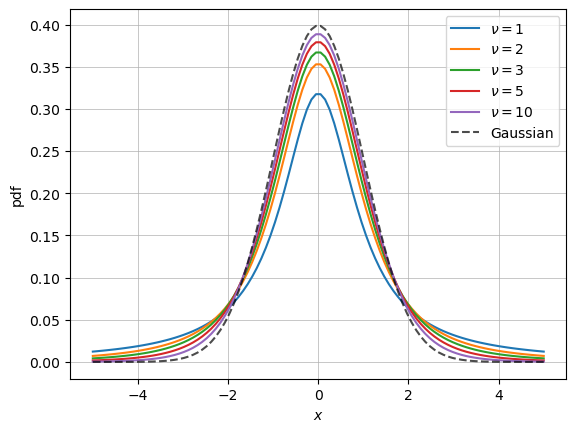

In [2]:
df_vec = [1, 2, 3, 5, 10]

ax = plt.axes()
for df in df_vec:
    x = np.linspace(-5, 5, 100)  # standardised
    ax.plot(x, stats.t.pdf(x, df), label=r"$\nu = %i$" % df)
    
ax.plot(x, stats.norm.pdf(x), 'k--', alpha=0.7, label="Gaussian")
ax.set_xlabel("$x$")
ax.set_ylabel("pdf")
ax.legend()
ax.grid(lw=0.5, zorder=0)

Below we are essentially redoing the sea-cucumber example as in the previous notebook, but with smaller samples, and testing the means.

## One sample t-test

Here we are testing one sample against the population mean. The null hypothesis is that there is no change. We follow essentially the same recipe, just with a smaller sample size (5 here instead of 100 previously). 

$t$-tests are easier to do in a way because `scipy.stats` already has that built it, and you don't even need to specify the degrees of freedom, because the code calculates that for you. The code spits out the $t$-statistic (like the Z-statistic from before) as well as the $p$-value; here we are going to be looking at the $p$-value. We reject the null hypothesis if the $p$-value is smaller than some threshold.

In [3]:
pop_mean = 3.0

# generate some data for the sake of it
np.random.seed(1)
sample_size, mean, std = 5, pop_mean+0.5, 0.5
data = mean + std * np.random.randn((sample_size))

alpha = 0.05  # standard number from Fisher
t_val, p_val = stats.ttest_1samp(data, pop_mean) # auto-magically takes into account data length to compute
                                                 # relevant t-statistic and the p values accordingly

print("=================")
print("t-test evaluation")
print("=================")
print(f"null hypothesis is that pop mean is {pop_mean}, threshold value of {alpha:.2f}")
print(f"(real sample mean is {mean})")
print(" ")
print(f"two-sided p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** pop mean != {pop_mean} is likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT null hypothesis")
    print(" ")
    print(f"    *** pop mean = {pop_mean} is not impossible ***")
    print(" ")
    print(f"(consider sample size, threshold etc.)")

t-test evaluation
null hypothesis is that pop mean is 3.0, threshold value of 0.05
(real sample mean is 3.5)
 
two-sided p-value from data sample is 0.1066933

  p-value not smaller than threshold, FAIL TO REJECT null hypothesis
 
    *** pop mean = 3.0 is not impossible ***
 
(consider sample size, threshold etc.)


> <span style="color:red">**Q.**</span> Interpret the above outcome with the seed set to 1.

> <span style="color:red">**Q.**</span> Consider asking the same questions as last time with the Z-test, such as what happens if you vary the $\alpha$, the differences in means, and sample size. Particularly look at increasing sample size.

## Two sample $t$-test

There are two of these, the **relative** case (where the two data sample size needs to be equal), and the **independence** case (where the two data sample size does not need to be equal). This is particularly useful for comparing between a control group and a test group.

Suppose we expose our sea cucumber to diet/exercise/whatever and want to see the effect on weight. The null hypothesis would be the means are the same, and other things are as usual (except here you are using the two sample $t$-test). The code below is for the relative test.

t-test evaluation
null hypothesis is that diet has no impact on weight, threshold value of 0.05
(real answer is it should have: from data, before mean is 2.895, after mean is 3.248)
 
two-sided p-value from data sample is 0.0373576

  p-value smaller than threshold, REJECT null hypothesis
 
    *** diet has impact on weight, likely at the alpha = 0.05 significance ***
 


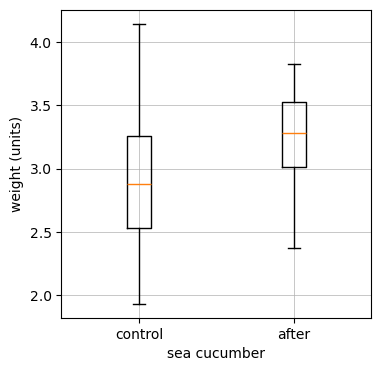

In [4]:
np.random.seed(2) # try 1 and 2
sample_size, mean, std = 20, 3.0, 0.5
data_before = mean + std * np.random.randn((sample_size))

# artificially going to make her heavier
np.random.seed(100)
data_after = (mean + 0.25) + std * np.random.randn((sample_size))

alpha = 0.05
t_val, p_val = stats.ttest_rel(data_before, data_after)

print("=================")
print("t-test evaluation")
print("=================")
print(f"null hypothesis is that diet has no impact on weight, threshold value of {alpha:.2f}")
print(f"(real answer is it should have: from data, before mean is {np.mean(data_before):.3f}, after mean is {np.mean(data_after):.3f})")
print(" ")
print(f"two-sided p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** diet has impact on weight, likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT null hypothesis")
    print(" ")
    print(f"    *** diet has no impact is not impossible ***")
    print(" ")
    print(f"(consider sample size, threshold etc.)")
    
# box-and-whisker plot to see the data
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.boxplot([data_before, data_after])
ax.set_xticklabels(["control", "after"])
ax.set_xlabel(r"sea cucumber")
ax.set_ylabel(r"weight (units)")
ax.grid(lw=0.5, zorder=0)

This one is for the independence or unpaired case, where the two sample sizes are not equal.

t-test evaluation
null hypothesis is that toy has no impact on weight, threshold value of 0.05
(real answer here is that it doesn't do anything)
 
two-sided p-value from data sample is 0.7776246

  p-value not smaller than threshold, FAIL TO REJECT null hypothesis
 
    *** toy has no impact on weight is not impossible ***
 
(consider sample size, threshold etc.)


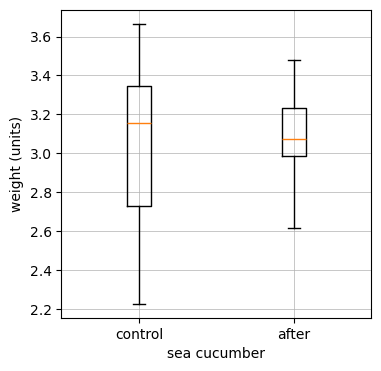

In [5]:
np.random.seed(10)
sample_size, mean, std = 6, 3.0, 0.5
data_before = mean + std * np.random.randn((sample_size))

# not going to do anything to the mean itself
sample_size, mean, std = 8, 3.0, 0.4
data_after = mean + std * np.random.randn((sample_size ))

alpha = 0.05  # standard number from Fisher
t_val, p_val = stats.ttest_ind(data_before, data_after)

print("=================")
print("t-test evaluation")
print("=================")
print(f"null hypothesis is that toy has no impact on weight, threshold value of {alpha:.2f}")
print(f"(real answer here is that it doesn't do anything)")
print(" ")
print(f"two-sided p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** toy has impact on weight, likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT null hypothesis")
    print(" ")
    print(f"    *** toy has no impact on weight is not impossible ***")
    print(" ")
    print(f"(consider sample size, threshold etc.)")
    
# box-and-whisker plot to see the data
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.boxplot([data_before, data_after])
ax.set_xticklabels(["control", "after"])
ax.set_xlabel(r"sea cucumber")
ax.set_ylabel(r"weight (units)")
ax.grid(lw=0.5, zorder=0)

The quartiles in the box plots are kind of like the confidence intervals: if one of the median lives outside of the other groups inter-quartiles you might expect there to a statistical significance to the difference.

> <span style="color:red">**Q.**</span> Do similar kind of explorations as before for the two sample case. Pay particular attention to the case where you vary the sample size (you have to be really careful of this when you are using the $t$-test and not make it too big, although for exploration reasons you could try and violate the condition and see what happens).

----------------
# b) $\chi^2$ test

**$\chi^2$ test** ("kai-squared") is generally used for categorical data with discrete probabilities, with the null hypothesis that the distributions of the two categories are the same. The $\chi^2$ pdf is given by

\begin{equation*}
    \mathrm{pdf} = \frac{x^{\nu/2-1}\mathrm{e}^{-x/2}}{2^{\nu/2}\Gamma(\nu/2)} \qquad \mathrm{if}\ x>0,
\end{equation*}

and zero otherwise. $\nu$ is again the degree of freedom, which is defined slightly different to the above case. It looks like the following.

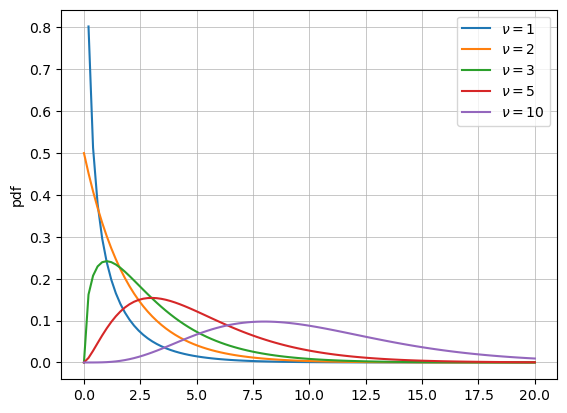

In [6]:
df_vec = [1, 2, 3, 5, 10]

ax = plt.axes()
for df in df_vec:
    x = np.linspace(0, 20, 100)  # standardised
    ax.plot(x, stats.chi2.pdf(x, df), label=r"$\nu = %i$" % df)
ax.set_ylabel("$x$")
ax.set_ylabel("pdf")
ax.legend()
ax.grid(lw=0.5, zorder=0)

A sensible example when you would use $\chi^2$-tests would be frequency of gene properties and its occurrence in different categories, to see if say one type of gene occurs more often. Another could be with rates of ~~disease~~ cursedness of population of specimens, you then expose samples of population to say a ~~stimulus~~ camera, and measure the ~~disease~~ cursedness, and you want to know if exposure to a ~~stimulus~~ camera results in changes to the rate of ~~disease~~ cursedness (cf. the Loki dog below).

<img src="https://i.imgur.com/5MXJpOU.jpg" width="400" alt='five tails'>

Below is a slightly easier example with a dice. Dice frequency counts as categorical data because you can't roll a 1.5 for example. The code is a brute force method to create a dice thrower (by default 6 sided fair die). To test out your Python, try and explain what the subroutine is actually doing.

In [7]:
def throw_n_sided_dice(side=6, bias=0):
    """
        use a brute force method to mimic dice throw 
        (could just use randint for a fair dice, might be a better way to do loaded dice)
    """
    a = np.random.rand()
    p = 1/side
    for i in range(side):
        if (a > i*p) & (a < (i+1)*p):
            if (np.random.rand() < bias): # dirty hack to bias the dice LOW (if bias = 0 then no bias)
                return np.max([1, i - np.random.randint(1, side)])
            else:
                return i+1

side = 6                         # choose number of sides a dice has
n = 120                          # throw n times
rolls = np.zeros(n, dtype=int)   # force output to be integers
for i in range(n):
    rolls[i] = throw_n_sided_dice(side=side)
print(f"actual output of rolls = {rolls}")

actual output of rolls = [6 4 3 3 4 4 5 6 1 1 1 4 2 3 2 2 3 5 3 6 5 4 4 1 1 2 1 2 3 6 6 4 4 2 2 4 3
 1 3 6 2 4 1 5 4 3 2 5 1 1 6 2 1 3 1 4 2 2 6 4 1 4 4 4 1 5 3 4 1 4 2 2 1 5
 3 6 5 4 4 5 3 3 2 6 3 1 1 1 4 4 3 5 3 3 5 4 2 6 6 1 2 2 3 5 1 2 3 6 4 3 4
 2 5 2 4 6 4 5 5 2]


It's a bit difficult to read the output so I am going to put this into a Pandas array. For the above case the rolls are fair, so I am also going to put the expected frequencies in.

In [8]:
freq = np.zeros(side)
for i in range(side):
    freq[i] = np.sum(rolls == i+1)          # Q. why the +1s etc?
roll_val = np.arange(side) + 1
expected_freq = 1/side * np.ones(side) * n  # Q. what is this doing?

# write this out into a pandas data frame for ease of reading
print()
print(f"=================================================")
print(f"summary table for the statistics of throw of dice")
print(f"=================================================")
df = pd.DataFrame(columns = ["roll_val", "freq", "expected_freq"])
df["roll_val"], df["freq"], df["expected_freq"] = roll_val, freq, expected_freq
print(df)


summary table for the statistics of throw of dice
   roll_val  freq  expected_freq
0         1  21.0           20.0
1         2  22.0           20.0
2         3  21.0           20.0
3         4  27.0           20.0
4         5  15.0           20.0
5         6  14.0           20.0


So now the question is we might ask is that ***given my dice throws, can I tell whether the dice is fair?*** 

Depending on whether you specified a seed or what not, chances are that the resulting frequencies are going to be slightly all over the place, but it is not implausible and a bit difficult to say just from looking at the frequencies by eye. You could roll it lots of times and sample the underlying pdf (which should be uniform if the dice is fair), but you might be waiting a while, and it would be difficult to do by hand say if you wanted to check it for a 20 sided dice that the Dungeon Meowster below would provide for a D&D game.

<img src="https://64.media.tumblr.com/1952b59b091940b9292416b44c203cb0/tumblr_p2ttki5Xye1rhz81io1_1280.jpg" width="600" alt='D&D game'>

You could do a $\chi^2$ test. The null hypothesis here is that the dice is fair, and the two distributions of the frequency are the same; what you expect below is that you will fail to reject the null hypothesis for this case (because my dice is fair). We will carry out a $\chi^2$ test at the 95% significance. In this case the degree of freedom is $(6 - 1) \times (2 - 1) = 5$ (6 outcomes minus 1, multiplied by 2 distributions minus 1), but the built-in function `stats.chisquare` will work this out for you by default.

In [9]:
alpha = 0.05

# if f_exp not provided then code assumes uniform distribution (which is actually the case here)
chi2, p_val = stats.chisquare(df["freq"], f_exp=df["expected_freq"])

print("====================")
print("chi2 test evaluation")
print("====================")
print(f"null hypothesis is that dice is fair, threshold value of {alpha:.2f}")
print(f"(real answer here in this case is that it is fair)")
print(" ")
print(f"p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** dice is not fair, at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT null hypothesis")
    print(" ")
    print(f"    *** not enough evidence to say dice is not fair ***")
    print(" ")
    print(f"(consider sample size, threshold etc.)")

chi2 test evaluation
null hypothesis is that dice is fair, threshold value of 0.05
(real answer here in this case is that it is fair)
 
p-value from data sample is 0.3261688

  p-value not smaller than threshold, FAIL TO REJECT null hypothesis
 
    *** not enough evidence to say dice is not fair ***
 
(consider sample size, threshold etc.)


As another demonstration, suppose you get another dice from the Loki dog above and it was biased. The subroutine written above allows for a dice to be biased (towards low values in this case), and we repeat the same test above but for a different throw with the biased dice. The null hypothesis, test and degrees of freedom are exactly the same, but here you do expect to be able to reject the null hypothesis (because the dice is unfair by construction).

In [10]:
side = 6                         # choose number of sides a dice has
n = 120                          # throw n times
rolls = np.zeros(n, dtype=int)   # force output to be integers
for i in range(n):
    rolls[i] = throw_n_sided_dice(side=side, bias=0.5)  # keep bias =< 1
print(f"actual output of rolls = {rolls}")

freq = np.zeros(side)
for i in range(side):
    freq[i] = np.sum(rolls == i+1)          # Q. why the +1s etc?
roll_val = np.arange(side) + 1
expected_freq = 1/side * np.ones(side) * n  # Q. what is this doing?

# write this out into a pandas data frame for ease of reading
print()
print(f"=================================================")
print(f"summary table for the statistics of throw of dice")
print(f"=================================================")
df = pd.DataFrame(columns = ["roll_val", "freq", "expected_freq"])
df["roll_val"], df["freq"], df["expected_freq"] = roll_val, freq, expected_freq
print(df)

alpha = 0.05
chi2, p_val = stats.chisquare(df["freq"], f_exp=df["expected_freq"])

print()
print("====================")
print("chi2 test evaluation")
print("====================")
print(f"null hypothesis is that dice is fair, threshold value of {alpha:.2f}")
print(f"(real answer here in the dice is biased low)")
print(" ")
print(f"two-sided p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** dice is not fair, at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT null hypothesis")
    print(" ")
    print(f"    *** not enough evidence to say dice is not fair ***")
    print(" ")
    print(f"(consider sample size, threshold etc.)")

actual output of rolls = [6 1 6 1 3 6 4 1 1 1 4 4 1 2 2 1 1 1 1 5 5 1 5 3 1 1 5 1 4 2 1 1 1 5 3 1 4
 4 2 1 1 1 1 3 1 1 1 3 4 2 1 6 1 4 6 1 1 3 1 5 5 2 4 2 1 3 1 1 1 1 1 5 4 2
 3 1 4 2 3 5 1 1 1 2 1 3 1 2 1 6 1 1 1 3 1 1 1 1 1 1 4 5 2 4 3 1 5 1 1 1 1
 1 1 2 1 6 1 1 6 2]

summary table for the statistics of throw of dice
   roll_val  freq  expected_freq
0         1  62.0           20.0
1         2  14.0           20.0
2         3  12.0           20.0
3         4  13.0           20.0
4         5  11.0           20.0
5         6   8.0           20.0

chi2 test evaluation
null hypothesis is that dice is fair, threshold value of 0.05
(real answer here in the dice is biased low)
 
two-sided p-value from data sample is 0.0000000

  p-value smaller than threshold, REJECT null hypothesis
 
    *** dice is not fair, at the alpha = 0.05 significance ***
 


> NOTE: The thing you should be aware of here is that the $\chi^2$ test in this case tells you there might be bias in the dice, but it doesn't tell you how *what* kind of bias is likely. I know the dice is biased low but that's because I made it bias low. It could also be biased high, to roll 1 more often, or roll even numbers more often, and the $\chi^2$ test does not tell you anything about the details.

> <span style="color:red">**Q.**</span> Plot out the histograms as well, as well as the histogram you actually expect. Choose either frequency or density (so the probability), it doesn't really matter.

> <span style="color:red">**Q.**</span> Try turning down the bias but keep the number of throws the same, when do you start not being able to reliable reject the null hypothesis? (You could make this very systematic by running lots of tests inside  a for loop say, and counting the frequency of false-positives or false negatives inside, depending on the case you are dealing with).

> <span style="color:red">**Q.**</span> Keeping a low-ish bias, try doing the same as above but varying the number of throws. (You could also try make this systematic like the above too)

> <span style="color:red">**Q.**</span> (harder) As above, but explore the Type I and/or Type II error behaviour in the (bias, number of throws) parameter space. You also want to do a collection of experiments to make sure your results are statistically representative.

-----------------
# c) Revisiting iris data: ANOVA and $F$-tests

The below pieces of code flies through the $t$-test and $\chi^2$ test for some sample data. I am not going to bother with being explicit about the null hypothesis, as the code is more for syntax demonstration (I am essentially redoing some of the following R stuff but in python from https://svaditya.github.io/oldblog/chi_square_and_t_tests_on_iris_data.html).

> <span style="color:red">**Q.**</span> To make this more fun/irritating for you, convince yourself whether I did the below stuff right or, if not, point our the error. Add some comments to the code too to help yourself later (I have been deliberately bad at putting comments in for this case).
>
> Hint: I have deleted the prompts so I don't even know where the errors are, but there should be seven coding, statistical as well as scientific errors in the code below.

In [11]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

print("===============================")
print("sample of data")
print("===============================")
print(df.sample(10))
print()
print("===============================")
print("some basic statistics from data")
print("===============================")
print(df.describe())

# slice out one of the species and have a look at the basic statistics
adelie_data = df.loc[df["species"] == "Adelie"]
chinst_data = df.loc[df["species"] == "Chinstrap"]
gentoo_data = df.loc[df["species"] == "Gentoo"]

loading data remotely
sample of data
    species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
125  Adelie            38.8           17.6              191.0       3275.0
110  Adelie            45.6           20.3              191.0       4600.0
270  Gentoo            46.8           14.3              215.0       4850.0
204  Gentoo            50.1           15.0              225.0       5000.0
244  Gentoo            49.5           16.1              224.0       5650.0
127  Adelie            39.0           17.1              191.0       3050.0
179  Gentoo            48.2           14.3              210.0       4600.0
67   Adelie            35.9           16.6              190.0       3050.0
182  Gentoo            42.8           14.2              209.0       4700.0
131  Adelie            36.8           18.5              193.0       3500.0

some basic statistics from data
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000

t test evaluation
null hypothesis of WHAT?, threshold value of 0.05
 
two-sided p-value from data sample is 0.0000000

  p-value smaller than threshold, REJECT null hypothesis
 
    *** CONCLUSION? likely at the alpha = 0.05 significance ***
 


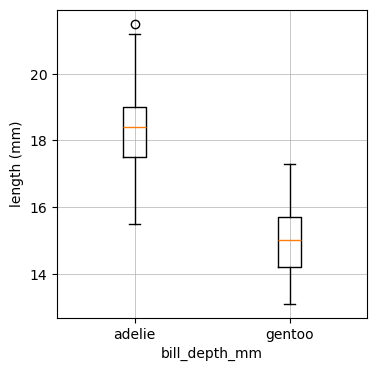

In [12]:
# t-test: want to show bill_depth_mm is affected by SPECIES

key = "bill_depth_mm"

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.boxplot([adelie_data[key], gentoo_data[key]])
ax.set_xticklabels(["adelie", "gentoo"])
ax.set_xlabel(f"{key}")
ax.set_ylabel(r"length (mm)")
ax.grid(lw=0.5, zorder=0)

alpha = 0.05

# randomly select 20 of them
in_data_1 = adelie_data[key].sample(20, random_state=69)
in_data_2 = gentoo_data[key].sample(20, random_state=69)

t_val, p_val = stats.ttest_rel(in_data_1, in_data_2)

print("=================")
print("t test evaluation")
print("=================")
print(f"null hypothesis of WHAT?, threshold value of {alpha:.2f}")
print(" ")
print(f"two-sided p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** CONCLUSION? likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, ACCEPT the null hypothesis")
    print(" ")
    print(f"    *** CONCLUSION??? ***")
    print(" ")

  above_mean  gentoo  adelie
0        yes       2      44
1         no      48       6

chi2 test evaluation
null hypothesis is WHAT, threshold value of 0.05
 
p-value from data sample is 0.0000000

  p-value smaller than threshold, REJECT null hypothesis
 
    *** WHAT? likely at the alpha = 0.05 significance ***
 


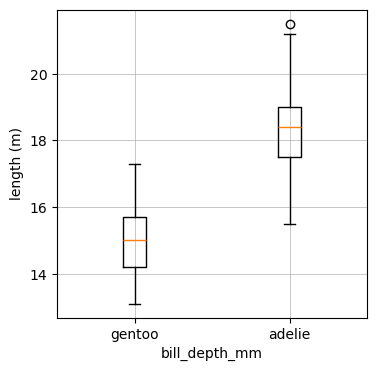

In [13]:
# chi2-test: want to show bill_depth is affected by SPECIES

key = "bill_depth_mm"

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.boxplot([gentoo_data[key], adelie_data[key]])
ax.set_xticklabels(["gentoo", "adelie"])
ax.set_xlabel(f"{key}")
ax.set_ylabel(r"length (m)")
ax.grid(lw=0.5, zorder=0)

in_data_1 = gentoo_data[key].sample(50, random_state=69)
in_data_2 = adelie_data[key].sample(50, random_state=69)

# Q. what is this doing? and why are we doing it?
mean_length = np.mean(np.concatenate([gentoo_data[key].values, adelie_data[key].values]))
df = pd.DataFrame(columns = ["above_mean", "gentoo", "adelie"])
df["above_mean"] = ["yes", "no"]
df["gentoo"] = [np.sum(in_data_1 > mean_length), 
                np.sum(in_data_1 < mean_length)]
df["adelie"] = [np.sum(in_data_2 > mean_length),
                np.sum(in_data_2 < mean_length)]

print(df)

chi2, p_val = stats.chisquare(df["gentoo"], f_exp=df["adelie"])

print()
print("====================")
print("chi2 test evaluation")
print("====================")
print(f"null hypothesis is WHAT, threshold value of {alpha:.2f}")
print(" ")
print(f"p-value from data sample is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** WHAT? likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, ACCEPT null hypothesis")
    print(" ")
    print(f"    *** WHAT? ***")
    print(" ")

## ANOVA and $F$-tests

The tests so far only allow you to compare two groups at a time, but suppose you want to compare the whole group, then what do you do? Beware here that is the issue of multiple testing, which can artificially inflate the occurrence of cases where you reject the null hypothesis. Below is the case for the means of the iris data.

In [14]:
# re-read the data
df = pd.read_csv(path)

# slice out one of the species and have a look at the basic statistics
adelie_data = df.loc[df["species"] == "Adelie"]
chinst_data = df.loc[df["species"] == "Chinstrap"]
gentoo_data = df.loc[df["species"] == "Gentoo"]

df_summary = pd.DataFrame(columns = ["stat", "Adelie", "Chinstrap", "Gentoo", "Total"])
df_summary["stat"] = ["bill_length_mm.mean", "bill_depth_mm.mean", 
                      "flipper_length_mm.mean", "body_mass_g.mean"]
df_summary["Adelie"]    = adelie_data.describe().values[1]  # 2nd index is the mean
df_summary["Chinstrap"] = chinst_data.describe().values[1]
df_summary["Gentoo"]    = gentoo_data.describe().values[1]
df_summary["Total"]     = df.describe().values[1]
df_summary

,stat,Adelie,Chinstrap,Gentoo,Total
0,bill_length_mm.mean,38.791391,48.833824,47.504878,43.921930
1,bill_depth_mm.mean,18.346358,18.420588,14.982114,17.151170
2,flipper_length_mm.mean,189.953642,195.823529,217.186992,200.915205
3,body_mass_g.mean,3700.662252,3733.088235,5076.016260,4201.754386


The means here are clearly different, but are they different enough to call statistical significance?

**Analysis of Variance (ANOVA)** is a set of tools to compare three or more groups of data means at the same time, so you could think of it as an extension of the $t$ and Z-tests. The "variance" bit in ANOVA refers to analysing the variance within the group, as well as the variance between the groups. The test statistic of interest (usually called the $F$-value, after Ronald Fisher) is a ratio of the two, and large $F$-value means the variation between groups dominates the variance within the groups. That is suggestive that the means depend more on the group, and indicative that the choice of group drives the variability and is a good predictor.

I am only going to do the **one way $F$-test**, which follows the $F$-distribution (but not going to bother plotting that outl you could adapt what I did above and try it; it resembles the $\chi^2$ distributions). We want to test whether the means of (say) `sepal.width` is predominantly driven by the variety of flower; recall from the PCA in *04_regression* that variety of flower seems to drive the difference in means through the clustering you see (the variety is a good predictor). So, the null hypothesis is that the means are exactly the same. We are going to do a one way $F$-test (because we only are only dealing with one variable, the mean here) at the 95% confidence level. The code below does this, and spits out both the $F$-value and $p$-value.

In [15]:
alpha = 0.05
key = "bill_depth_mm"
f_val, p_val = stats.f_oneway(adelie_data[key], chinst_data[key], gentoo_data[key])

print("=================")
print("F-test evaluation")
print("=================")
print(f"null hypothesis that all means are the same, threshold value of {alpha:.2f}")
print(f"(for the Iris data the means between Setosa and the rest are quite different)")
print(" ")
print(f"one-sided f-value from data set is {f_val:.7f}, p-value is {p_val:.7f}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** at least one pair with different mean, likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT the null hypothesis")
    print(" ")
    print(f"    *** cannot conclude means are different ***")
    print(" ")

F-test evaluation
null hypothesis that all means are the same, threshold value of 0.05
(for the Iris data the means between Setosa and the rest are quite different)
 
one-sided f-value from data set is 359.7891488, p-value is 0.0000000

  p-value smaller than threshold, REJECT null hypothesis
 
    *** at least one pair with different mean, likely at the alpha = 0.05 significance ***
 


Again, note that the $F$-test only tells you the means are different, but it doesn't tell you which pair is different (see **Tukey HSD** shortly).

> <span style="color:red">**Q.**</span> I did this for one of the variables but you could try it for another variable.

> <span style="color:red">**Q.**</span> See if you can look up to see how you test multiple things at the same time.

-------------------
# d) Misc ending words

The tests we have done so far all have their own assumptions that go with it. For example, the $F$-test assumes data are independent, Gaussian distributed and homogeneity of variances, and is particularly sensitive to these things (e.g. if variances between groups vary a lot and/or sample sizes very different, then tests could be under-powered and susceptible to Type II errors). I have skipped a lot of the pre-/post-tests to check various things, but some of these are:

* box plots and/or histograms of the data
* **Shapiro-Wilk's test** (`scipy.stats.shapiro`) for normality of data
* **Levene's test** (`scipy.stats.levene`) for homogeneity of variances
* **Barlett's test** (`scipy.stats.bartlett`) for homogeneity of variances
* **Tukey's honest significance test** (in `statsmodel` package, such as `statsmodels.stats.multicomp.pairwise_tukeyhsd`), to test for which pairs of means are different in the $F$-test

Not only are there these tests, there are other hypothesis testing you can use, each with their own assumptions (see [here](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/) for example). We could spend a whole course going through these, but the aim here is to really get you familiar with some of the procedure, interpretation, Python syntax, and general banana skins to bear in mind, so that you can take it further yourself.

Again, ***(perfect) practice makes perfect!*** I have tried to note the things you should be careful of so you can get closer to perfect, the actual time to put in the practice is down to you.

> <span style="color:red">**Q.**</span> Try a few of the tests named above for the data we have (look up Google or the manual for syntax). Try and cook up examples that obvious satisfy and/or violate the tests as a way to test the tools you are using (e.g. cook up non-Gaussian distributed data with the Shapiro-Wilk's test).

> <span style="color:red">**Q.**</span> (tedious?) Try and do things I have done so far, but using the `statsmodel` package, which looks like it would do everything in one call. I have refrained from using it here precisely because it makes things a bit too easy, so you never really see the details and probe where you can go wrong.

## Some good practices with hypothesis testing

Non-exhaustive, you can probably find more. Some of these are in line with the advises of the professional statistical societies.

* Take your time in getting the interpretation correct, be wary of perpetuating misconceptions, which can lead to false claims or over-claims.


* If you use the $p$-value, report the full $p$-value, rather than the (overly) simple "we reject the null" or "we don't reject the null". The $\alpha=0.05$ is a convention, and just because you have $\alpha=0.051$ does not mean something is necessarily insignificant (and it certainly does not mean the null is true/false, since statistical tests don't tell you anything of the sort).


* Consider using confidence intervals instead. I haven't gone through this here, but confidence intervals tell you the $p$-value things and more.


* Report the sample size, power, experimental design, and make data available if possible, partly for reproducibility. Statistics by its nature "coarsens" the details and leaves you with less information in a way. The devil is really in the details, so having ways to reproduce details is a good way to foster progress.


* Just like ***correlation is not causation***, ***statistical significance is not practical significance***! The hypothesis tests only give you the statistical significance aspect (and sometimes you can be wrong, but you want to know how wrong), but the interpreter has to make the call on whether something is of practical significance. The confidence interval is more useful in giving you information to make the call.


* ***Do not for God sake torture the data until it confesses!*** See this too many times, sometimes unwittingly, and on occasions maliciously, for the sake of trying to get a publication. The convention that only things below $\alpha=0.05$ is publishable in science I think is a massive dis-service to science, because 1) it's a rather arbitrary convention that in cases is not applicable, 2) $p$-value below some arbitrary threshold does not mean what most people think it means either, and 3) a significant false-positives result for this rather slack threshold anyway (see an exercise in the *05_statistical_tests*).

----------------
# More involved exercises with this notebook

## 1) Iris

You know what to do (well you should by now).

## 2) Conceptual: the spiteful (?) sea-cucumber

<img src="https://i.imgur.com/Zn225sX.jpg" width="400" alt='angers'>

Around Chinese New Year I was talking with my family, and I noted that Miffy seems to have a tendency to poo around the time when we would be eating. This might of course be confirmation bias from our end, but it is not inconceivable she would do this out of spite given the kind of things we put her through, who knows?

<img src="https://c.tenor.com/NAH83oVLQLQAAAAC/movie-action.gif" width="400" alt='inigo'>

(Random pop culture reference, fake internet points for whoever gets the reference.)

The conversations then got on to how one might actually try and ascertain this statistically. So how would you do a hypothesis test? Things to think about are:

* What statistical power might you want?
* Given the choice of power, how many samples might you need? What are the practical considerations you might need to bear in mind?
* What would be your null?
* What test would you do?
* Given the null, what might be in your control group?
* Cook up some data and carry out a statistical test in Python, and conclude accordingly depending on how you decide to cook up the data
* There are confounding and missing factors not taken into account, so how might you modify your test accordingly?

## 3) (hard-ish) $F$-test as goodness of fit for linear regression models

Similar to A/BIC introduced in *04_regression*, the $F$-values can be used to say whether a linear regression model is significantly better than another, weighted accordingly by the number of parameters (look up "F-test" on Wikipedia, towards the end of the page).

Try and adapt the existing $F$-test commands etc., to test for goodness of fit between two models. Some of those could be the ones I made up in that notebook, but you can try your own. One particular thing to try are **nested models**: a model $f$ is nested within $g$ is $g$ contains $f$ as a subset (e.g. $f = ax + b$ and $g = cx^2 + ax + b$, or by including more inputs).

## 4) (more probability based) Shannon (diversity) index

A often used index for diversity in ecology is the [***Shannon index/entropy***](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index); it is not the only one, but I will focus on this because it has additional uses. The Shannon entropy is defined as
\begin{equation*}
H = -\sum_{i=1}^n p_i \log_a p_i,
\end{equation*}
where $p_i$ is the probability of occurrence of a type, and $a$ is a base of the logarithm function that varies somewhat depend on taste ($2$ for the index as Shannon defined, $10$ is also a popular choice, but any positive number is fine really; I will use the natural log with base $e$).

> NOTE: The log functions can be called respectively by `np.log2`, `np.log10` and `np.log`.

Notice that $H = 0$ is there is only 1 species ($n=1$, since $p_1 = 1$ and $\log_a 1 = 0$ regardless of base). On the other hand, $H$ is maximised for fixed $n$ if we have a uniform distribution ($p_i = 1/n$ for all $i$), and in that case $H = -\log 1/n = \log n$. One way to think of $H$ is the amount of **surprise** or **information** you get from doing a random sample from the dataset: $H=0$ is no surprise and perfect information (because there is only one species so you know exactly what you should get from a random draw), while high $H$ means the converse. The example below computes this for the Iris data based on `variety` using mostly `Pandas` commands.

> NOTE: `df["variety"]` only picks out species. `.value_counts(normalize=True)` bins the occurences according to unique entries (three species here), and `normalize` divides it by total number, i.e. computing the probabilities or normalised histograms. The answer here should be `log 3` because the Iris dataset has 50 entries of each species.

In [16]:
# data load

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "iris.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/iris.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


In [17]:
# shannon index for all iris data based on species

dum = df["variety"].value_counts(normalize=True)  # compute normalised probabilities
H = (-dum * np.log(dum)).sum()                    # compute shannon index with natural log
print(f"H = {H:.6f} in base e")

# pick out number of unique entries
num_unique = len(df["variety"].unique())
print(f"maximum possible Shannon entropy = {np.log(num_unique):.6f}")

H = 1.098612 in base e
maximum possible Shannon entropy = 1.098612


One of the things of interest here is the ***added information*** but further segmentation: suppose I add segment further by an additional feature (e.g. `sepal.length`), how much information am I gaining? If high entropy is low information, then the goal is to *reduce* the resulting entropy. A quantity to calculate is the ***information gain***, defined as
\begin{equation*}
    \mbox{IG} = H_p - \sum_i^n p_{c,i} H_{c,i},
\end{equation*}
where $H_p$ is the parent entropy, $p_{c_i}$ is the probability of occurrence for the child, and $H_{c,i}$ is the entropy of the child. It is probably easier to go through an example to make sense of what everything is (I got confused when I did this for the first time).

1. Compute $H_p$. For the parent being `variety`, we have done that already.

2. Split the data according to `sepal.length`. This is a numerical set of data, so we would bin this. This could be done by the following in `pandas` (e.g. 32 entries for `sepal.length` between 4.295 and 5.02 mm).

In [18]:
df["sepal.length"].value_counts(bins=5)  # bin according to one attribute

(5.74, 6.46]     42
(5.02, 5.74]     41
(4.295, 5.02]    32
(6.46, 7.18]     24
(7.18, 7.9]      11
Name: count, dtype: int64

In [19]:
out = pd.cut(df["sepal.length"], 5)  # cut the data and return bins
out

0       (5.02, 5.74]
1      (4.296, 5.02]
2      (4.296, 5.02]
3      (4.296, 5.02]
4      (4.296, 5.02]
           ...      
145     (6.46, 7.18]
146     (5.74, 6.46]
147     (6.46, 7.18]
148     (5.74, 6.46]
149     (5.74, 6.46]
Name: sepal.length, Length: 150, dtype: category
Categories (5, interval[float64, right]): [(4.296, 5.02] < (5.02, 5.74] < (5.74, 6.46] < (6.46, 7.18] < (7.18, 7.9]]

3. Find the number of `variety` in those `sepal.length` bins, and compute the occurrences and entropies accordingly. The below does this by creating the bins, finding the indices corresponding to the unique bins, pick out the data, and then computing the entropies.

In [20]:
bins = out.unique()  # find the number of unique entries based on intervals
bins

[(5.02, 5.74], (4.296, 5.02], (5.74, 6.46], (6.46, 7.18], (7.18, 7.9]]
Categories (5, interval[float64, right]): [(4.296, 5.02] < (5.02, 5.74] < (5.74, 6.46] < (6.46, 7.18] < (7.18, 7.9]]

In [21]:
# compute intermediate variables
p_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # initialise
for i in range(len(bins)):
    ind = (out == bins[i])
    n_i[i] = df[ind]["variety"].value_counts().sum()
    dum = df[ind]["variety"].value_counts(normalize=True)
    p_i[i] = (-dum * np.log(dum)).sum()

In [22]:
# compute information gain
IG = H - np.sum(p_i * n_i / np.sum(n_i))
print(f"IG = {IG:.6f}")

IG = 0.443782


The resulting $\mbox{IG}$ is positive (i.e. the resulting $H$ is lower than your starting $H$), so you are getting extra information.

By itself it is somewhat meaningless, so probably best to do this for another variable.

In [23]:
out = pd.cut(df["sepal.width"], 5)
bins = out.unique()
p_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # initialise
for i in range(len(bins)):
    ind = (out == bins[i])
    n_i[i] = df[ind]["variety"].value_counts().sum()
    dum = df[ind]["variety"].value_counts(normalize=True)
    p_i[i] = (-dum * np.log(dum)).sum()
IG = H - np.sum(p_i * n_i / np.sum(n_i))
print(f"IG = {IG:.6f}")

IG = 0.271350


So this one is suggesting segmenting on `sepal.width` is not as "good".

This is one way of identifying important features as a compliment to something like PCA. These kind of ideas are used in machine learning algorithms when creating segmentations in decision trees.

> <span style="color:red">**Q.**</span> Try this for other variables in the iris data.
>
> <span style="color:red">**Q.**</span> I followed the example written in R in https://rpubs.com/philjet/shannonentropy for the above (except for the intermediate entropy calculations where I don't think it is returning correct values). Reproduce some of the exploration of the data there but here in Python.
>
> <span style="color:red">**Q.**</span> Do something similar for the Penguin data. Note that the Penguin data is not distributed uniformly in terms of species.
>
> <span style="color:red">**Q.**</span> See how you might do this for a language with an alphabet (e.g. English vs. German). This is somewhat what Shannon did in one of his papers, and is related to Natural Language Processing, text prediction, noise correction and similar things (redundancies are good for correction purposes, e.g. if I had `? am` and `?` is a missing piece of data, then `?` is probably `I`).
>
> I had a student who once computed the entropy of the languages using the Communist Manifesto by Marx and Engles as part of a project (crawling through the text and computing the histogram of the alphabets). You could try that too, although I would start with something smaller.
>
> (We don't touch on gene data in this course, but this is how you might do things with it, but reading the data as a string, segmenting and/or categorising it, and turning it into numerical data, and continue as before.)